In [19]:
# Analyze SageMaker HPO Tuning Results
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [33]:
#Config 
tuning_jobs = sm.list_hyper_parameter_tuning_jobs(MaxResults=10)
tuning_job_name = sorted(
    [j["HyperParameterTuningJobName"] for j in tuning_jobs["HyperParameterTuningJobSummaries"]],
    reverse=True)[0]

sm = boto3.client("sagemaker")

#  Fetch all completed training jobs
response = sm.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    StatusEquals="Completed"
)

training_jobs = response["TrainingJobSummaries"]
metrics = []

#Extract metrics from each job
for job in training_jobs:
    job_name = job["TrainingJobName"]
    job_desc = sm.describe_training_job(TrainingJobName=job_name)

    metrics.append({
        "TrainingJobName": job_name,
        "eta": float(job_desc["HyperParameters"]["eta"]),
        "max_depth": int(job_desc["HyperParameters"]["max_depth"]),
        "validation:auc": float(job_desc["FinalMetricDataList"][0]["Value"]),
        "training_time": job_desc["TrainingTimeInSeconds"]
    })

#  Convert to DataFrame
df = pd.DataFrame(metrics).sort_values(by="validation:auc", ascending=False)
display(df.head())

,TrainingJobName,eta,max_depth,validation:auc,training_time
4,sagemaker-xgboost-250510-1352-006-d1988a79,0.193317,4,0.98895,99
1,sagemaker-xgboost-250510-1352-009-fbd62479,0.192030,4,0.98893,99
6,sagemaker-xgboost-250510-1352-004-92f15438,0.193941,4,0.98889,94
0,sagemaker-xgboost-250510-1352-010-f3bf25a9,0.185236,4,0.98885,99
2,sagemaker-xgboost-250510-1352-008-9ee1b817,0.250665,4,0.98876,99


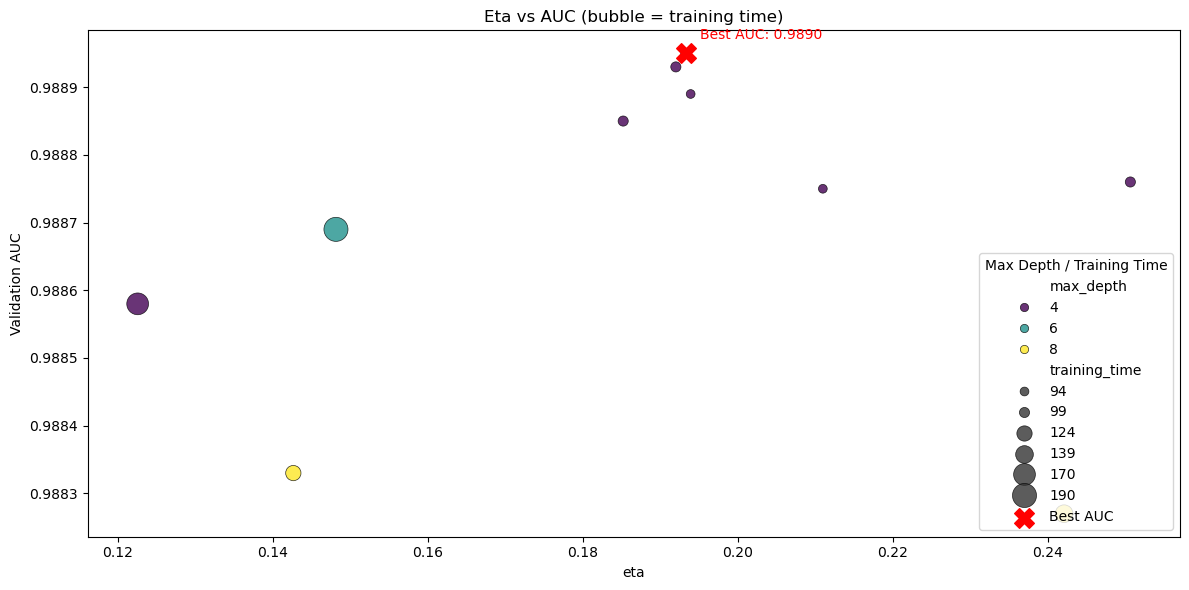

In [31]:
best = df.iloc[0]

#eta vs AUC with bubble = training time
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=df,
    x="eta", y="validation:auc",
    size="training_time", hue="max_depth",
    palette="viridis", sizes=(40, 300), alpha=0.8, edgecolor="black"
)
plt.scatter(best["eta"], best["validation:auc"], color="red", s=200, label="Best AUC", marker="X")
plt.legend(loc="lower right", title="Max Depth / Training Time")
plt.title("Eta vs AUC (bubble = training time)")
plt.xlabel("eta")
plt.ylabel("Validation AUC")

#  Annotate best job
plt.annotate(f"Best AUC: {best['validation:auc']:.4f}",
             (best["eta"], best["validation:auc"]),
             textcoords="offset points",
             xytext=(10, 10),
             ha='left',
             fontsize=10,
             color="red")

plt.tight_layout()
plt.show()

/var/folders/g2/xx5xrh3d7rgfc8tp3b3cn9jr0000gn/T/ipykernel_60839/2590777275.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=tmpdir)


✅ Booster loaded from models/heart_attack/20250510T063154Z/output/xgb-heart-20250510T063154Z/output/model.tar.gz
✏️  Reading header from: data/processed_data/phase4_pruned_all_latest_0445.csv
🔧 Canonical feature list (first 5): ['age_group', 'sex', 'income', 'marital_status', 'race_ethnicity'] … total 44
✅ Loaded validation: 86,151 rows × 44 features


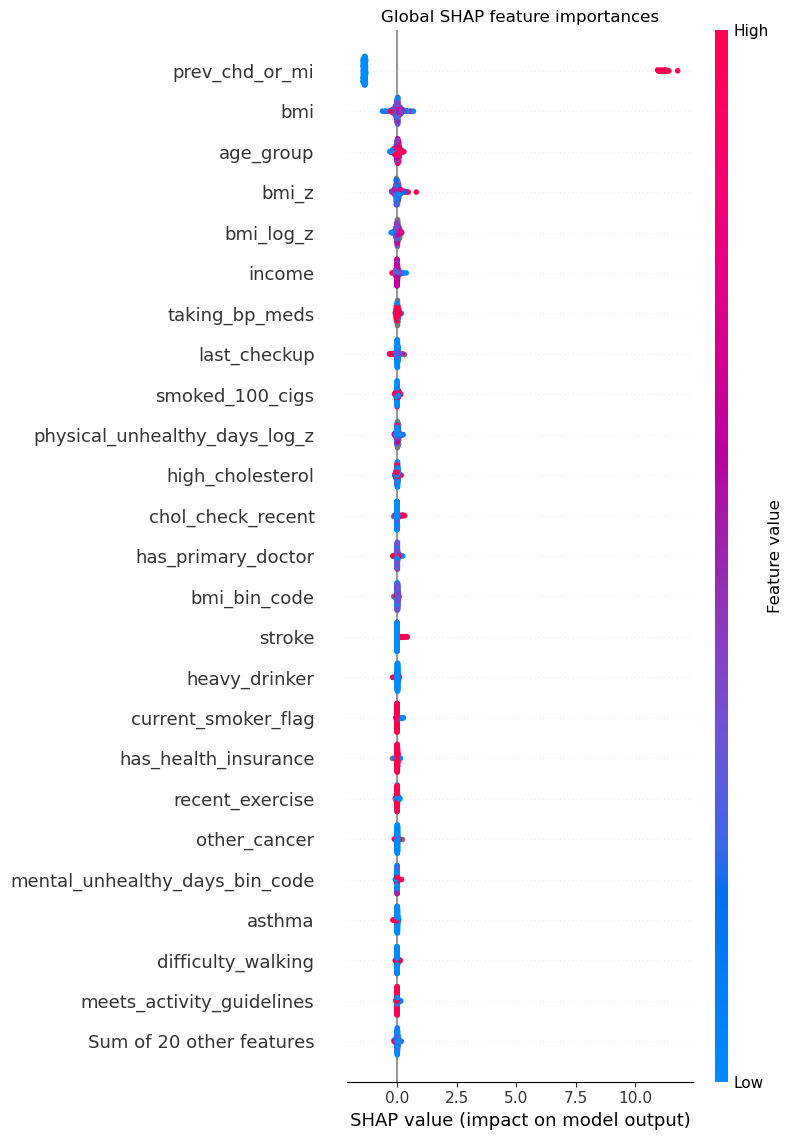

In [5]:
import boto3, tarfile, tempfile, os, shap, xgboost as xgb, pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

# Config
bucket      = "verikai-heart-risk-pipeline"
model_key   = "models/heart_attack/20250510T063154Z/output/xgb-heart-20250510T063154Z/output/model.tar.gz"
raw_prefix  = "data/processed_data"   
val_key     = f"{raw_prefix}/validation.csv"
n_shap      = 200                

s3 = boto3.client("s3")

#Download & unpack the SageMaker model
tmpdir  = tempfile.mkdtemp()
tarpath = os.path.join(tmpdir, "model.tar.gz")
s3.download_file(bucket, model_key, tarpath)
with tarfile.open(tarpath) as tar:
    tar.extractall(path=tmpdir)

bst = xgb.Booster()
bst.load_model(os.path.join(tmpdir, "xgboost-model"))
print("Booster loaded from", model_key)
resp = s3.list_objects_v2(Bucket=bucket, Prefix=raw_prefix + "/")
all_csv = [o["Key"] for o in resp.get("Contents",[]) if o["Key"].endswith(".csv")]
# exclude the split files (train.csv / validation.csv)
orig_csv = sorted(
    [k for k in all_csv if "train.csv" not in k and "validation.csv" not in k],
    reverse=True
)[0]
print(" Reading header from:", orig_csv)

#Read the header row
header_df    = pd.read_csv(
    StringIO(s3.get_object(Bucket=bucket, Key=orig_csv)["Body"]
             .read().decode("utf-8")), 
    nrows=0
)
cols         = header_df.columns.tolist()
cols.remove("heart_attack")    # drop the target
print("🔧 Canonical feature list (first 5):", cols[:5], "… total", len(cols))

#Load the validation split (no header) and assign names
val_df = pd.read_csv(
    StringIO(s3.get_object(Bucket=bucket, Key=val_key)["Body"]
             .read().decode("utf-8")),
    header=None
)
val_df.columns = ["heart_attack", *cols]
X = val_df.drop(columns="heart_attack")
print(f"Loaded validation: {len(X):,} rows × {X.shape[1]} features")

#One‑hot → reindex to *exactly* the training cols
X_enc = pd.get_dummies(X)
X_enc = X_enc.reindex(columns=cols, fill_value=0)

X_sample = X_enc.sample(n=min(n_shap_rows, len(X_enc)), random_state=42)

#build a TreeExplainer (this auto‑detects Booster)
explainer = shap.Explainer(bst, X_sample)

#compute SHAP values (passing the DataFrame retains column names)
shap_values = explainer(X_sample)

# beeswarm
plt.figure(figsize=(10,6))
shap.plots.beeswarm(
    shap_values,
    max_display=25,        # top 25 by mean|SHAP|
    show=False
)
plt.title("Global SHAP feature importances")
plt.tight_layout()
plt.show()

In [ ]:
# import json
# import os
top_auc = df.iloc[0]["validation:auc"]
top_eta = df.iloc[0]["eta"]
top_depth = df.iloc[0]["max_depth"]
top_job = df.iloc[0]["TrainingJobName"]

metadata = {
    "top_auc": round(top_auc, 4),
    "top_eta": top_eta,
    "top_depth": top_depth,
    "best_hpo_job": top_job
}

os.makedirs("/opt/airflow/out", exist_ok=True)
with open("/opt/airflow/out/notebook_output_metadata.json", "w") as f:
    json.dump(metadata, f)

print("Metadata for HPO analysis written.")
